# Generating matrix of the rsem estimated_counts

In [1]:
# Loading results

library(tidyverse)

setwd("C:\\Users\\mapanavici\\RStudio\\R")

Ov4Carbopool3 <- read.delim("WTCHG_626197_201106_.genes.results", header = TRUE)

Ovcar4Parental1 <- read.delim("WTCHG_626197_289105_.genes.results", header = TRUE)

Ovcar4Parental2 <- read.delim("WTCHG_626197_290117_.genes.results", header = TRUE)

Ovcar4Parental3 <- read.delim("WTCHG_626197_291129_.genes.results", header = TRUE)

Ov4Carbopool1 <- read.delim("WTCHG_626197_295177_.genes.results", header = TRUE)
 
Ov4Carbopool2 <- read.delim("WTCHG_626197_296189_.genes.results", header = TRUE)


── Attaching packages ─────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.0      ✔ purrr   0.3.5 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.5.0 
✔ readr   2.1.3      ✔ forcats 0.5.2 
Warning message:
"package 'ggplot2' was built under R version 4.2.2"
Warning message:
"package 'stringr' was built under R version 4.2.2"
── Conflicts ────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


In [2]:
# Obtaining "gene_id" and "expected_count" columns, renaming "expected_count" column to individual sample.names

get_counts <- function(sample_df) {
  
  id_and_counts <- select(sample_df, gene_id, expected_count)
  names(id_and_counts)[2] <- deparse(substitute(sample_df))
  
  return(id_and_counts)
}

df1 <- get_counts(Ovcar4Parental1)
df2 <- get_counts(Ovcar4Parental2)
df3 <- get_counts(Ovcar4Parental3)
df4 <- get_counts(Ov4Carbopool1)
df5 <- get_counts(Ov4Carbopool2)
df6 <- get_counts(Ov4Carbopool3)

In [4]:
# Merging all data sets by "gene_id" column 

rawCounts <- list(df1, df2, df3, df4, df5 ,df6) %>% 
                reduce(inner_join, by='gene_id')

head(rawCounts)

,gene_id,Ovcar4Parental1,Ovcar4Parental2,Ovcar4Parental3,Ov4Carbopool1,Ov4Carbopool2,Ov4Carbopool3
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,ENSG00000000003,896,908,1009,823,894,898
2,ENSG00000000005,0,0,0,0,0,0
3,ENSG00000000419,1733,1410,1647,1584,2701,2206
4,ENSG00000000457,157,125,168,173,282,192
5,ENSG00000000460,501,541,705,401,543,564
6,ENSG00000000938,0,0,0,0,0,0


# Differential Expression Analysis

In [6]:
options(warn = -1)

if (!require("BiocManager", quietly = TRUE)) 
  install.packages("BiocManager") 
  BiocManager::install("DESeq2")

library("DESeq2")

'getOption("repos")' replaces Bioconductor standard repositories, see
'?repositories' for details

replacement repositories:
    CRAN: https://cran.r-project.org


Bioconductor version 3.15 (BiocManager 1.30.19), R 4.2.1 (2022-06-23 ucrt)

Old packages: 'bookdown', 'broom', 'bslib', 'cli', 'digest', 'doRNG',
  'evaluate', 'formatR', 'highr', 'htmlwidgets', 'httpuv', 'isoband',
  'maptools', 'nlme', 'purrr', 'rmarkdown', 'RSQLite', 'shiny', 'tidytree',
  'tinytex', 'vctrs', 'xfun', 'yulab.utils'



In [7]:
# Tidying up the data for DESeq2

rownames(rawCounts) <- rawCounts$gene_id

rawCounts <-  select(rawCounts, -1)

rawCounts <- ceiling(rawCounts) # converting floats to int for DESeq2

head(rawCounts)


,Ovcar4Parental1,Ovcar4Parental2,Ovcar4Parental3,Ov4Carbopool1,Ov4Carbopool2,Ov4Carbopool3
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSG00000000003,896,908,1009,823,894,898
ENSG00000000005,0,0,0,0,0,0
ENSG00000000419,1733,1410,1647,1584,2701,2206
ENSG00000000457,157,125,168,173,282,192
ENSG00000000460,501,541,705,401,543,564
ENSG00000000938,0,0,0,0,0,0


In [8]:
# Inputting - Sample Groups

sampleData <- read.delim("sample_IDs.csv", header = T)

sampleData <- sampleData %>% 
      separate(sample.name.group, c("sample.name", "group"))

head(sampleData)

,sample.name,group
,<chr>,<chr>
1,Ovcar4Parental1,sensitive
2,Ovcar4Parental2,sensitive
3,Ovcar4Parental3,sensitive
4,Ov4Carbopool1,resistant
5,Ov4Carbopool2,resistant
6,Ov4Carbopool3,resistant


In [10]:
# Creating DESeq2 object

dds <- DESeqDataSetFromMatrix(countData = rawCounts,
                              colData = sampleData,
                              design = ~ group)

dds

converting counts to integer mode



class: DESeqDataSet 
dim: 61541 6 
metadata(1): version
assays(1): counts
rownames(61541): ENSG00000000003 ENSG00000000005 ... ENSG00000289643
  ENSG00000289644
rowData names(0):
colnames(6): Ovcar4Parental1 Ovcar4Parental2 ... Ov4Carbopool2
  Ov4Carbopool3
colData names(2): sample.name group

In [11]:
# Filtering out low count genes - allowing 10 counts in at least 3 samples

keep <- rowSums(counts(dds) >= 10) >= 3

dds <- dds[keep,]

In [21]:
# Running DESeq2 algo

dds <- DESeq(dds)

using pre-existing size factors

estimating dispersions

found already estimated dispersions, replacing these

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



In [13]:
# Using unsupervised clustering to see the relationship among two groups

# Data normalization

norm.counts <- counts(dds, normalized=TRUE)

write.csv(norm.counts, file="normalized_counts.txt", row.names=TRUE)

head(norm.counts)

# Data transformation (using variance stabilizing transformations (VST) which produces transformed data on the log2 scale, 
# normalized with respect to library size)

vsd <- vst(dds, blind=FALSE)

head(assay(vsd))

,Ovcar4Parental1,Ovcar4Parental2,Ovcar4Parental3,Ov4Carbopool1,Ov4Carbopool2,Ov4Carbopool3
ENSG00000000003,868.5490,1010.9747,987.0680,908.6342,776.0136,881.1733
ENSG00000000419,1679.9055,1569.9057,1611.2002,1748.8173,2344.5334,2164.6640
ENSG00000000457,152.1899,139.1760,164.3483,191.0009,244.7828,188.4023
ENSG00000000460,485.6507,602.3539,689.6758,442.7246,471.3371,553.4318
ENSG00000000971,491.4669,950.8507,805.1109,228.5386,366.3062,877.2482
ENSG00000001036,1343.5367,1475.2660,1338.2646,1055.4731,1120.6192,1533.7125


,Ovcar4Parental1,Ovcar4Parental2,Ovcar4Parental3,Ov4Carbopool1,Ov4Carbopool2,Ov4Carbopool3
ENSG00000000003,9.929855,10.126994,10.095738,9.988132,9.785521,9.948465
ENSG00000000419,10.804267,10.712576,10.747685,10.858869,11.260481,11.150564
ENSG00000000457,7.966106,7.884723,8.037823,8.182649,8.434630,8.169200
ENSG00000000460,9.205757,9.467683,9.636318,9.095802,9.170033,9.363690
ENSG00000000971,9.220019,10.047051,9.832493,8.363318,8.875983,9.942705
ENSG00000001036,10.503236,10.628728,10.497979,10.183420,10.262225,10.681084


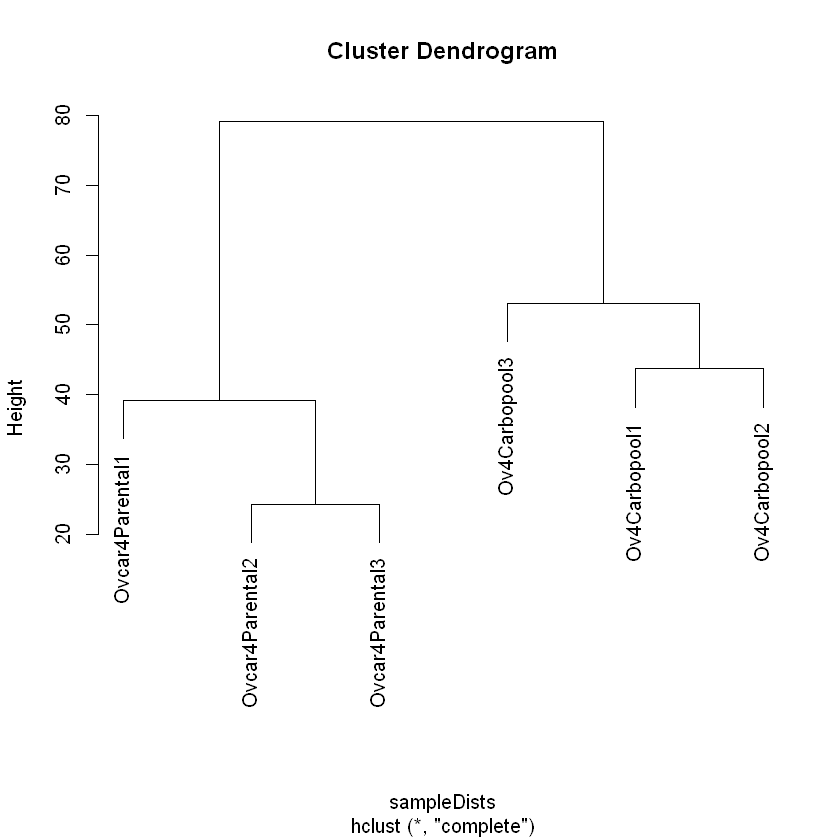

In [14]:
# Hierarchical clustering (dendrogram)

sampleDists <- dist(t(assay(vsd)))
plot(hclust(sampleDists, method = "complete"))

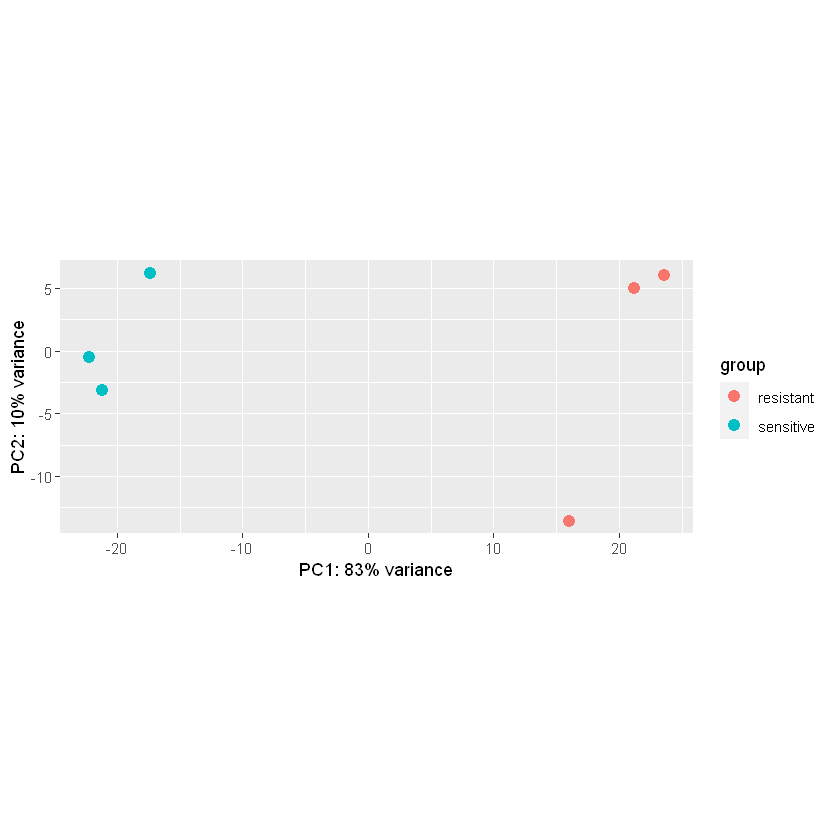

In [15]:
# PCA

plotPCA(vsd, intgroup=c("group"))

Clear separation between two groups

In [16]:
# Getting the results of differential expression analysis
res <- results(dds, contrast=c("group", "sensitive", "resistant"))

# Viewing summary of results

summary(res)
#head(res)
#mcols(res)$description


out of 15495 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 2244, 14%
LFC < 0 (down)     : 2024, 13%
outliers [1]       : 7, 0.045%
low counts [2]     : 0, 0%
(mean count < 6)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



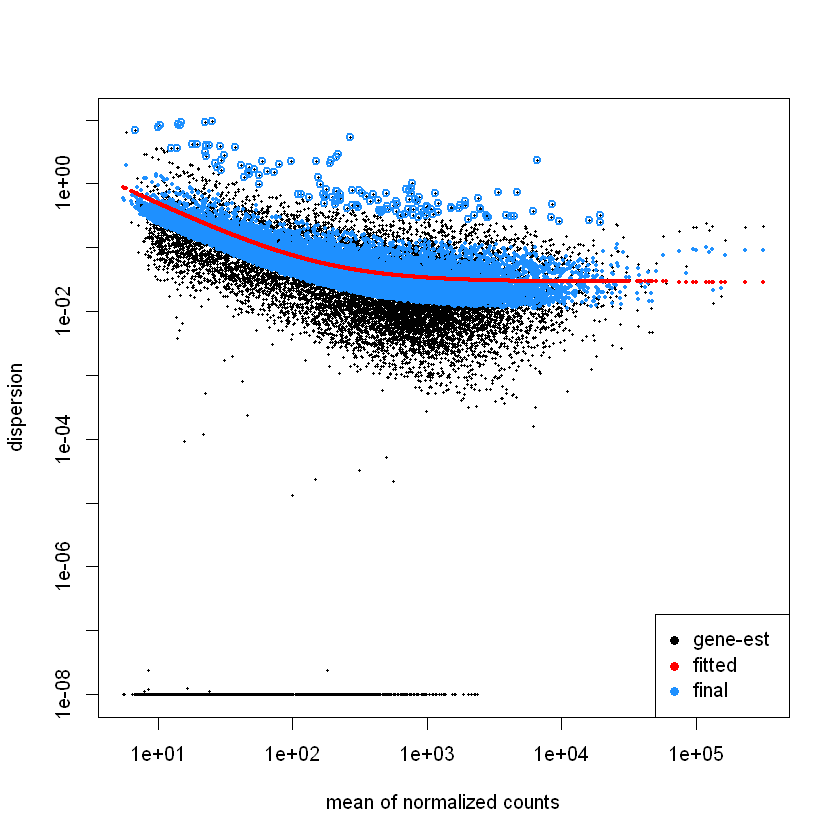

In [17]:
# Diagnostics - observing how well the data has been captured by the model (plotting Dispersion Estimates)

plotDispEsts(dds)

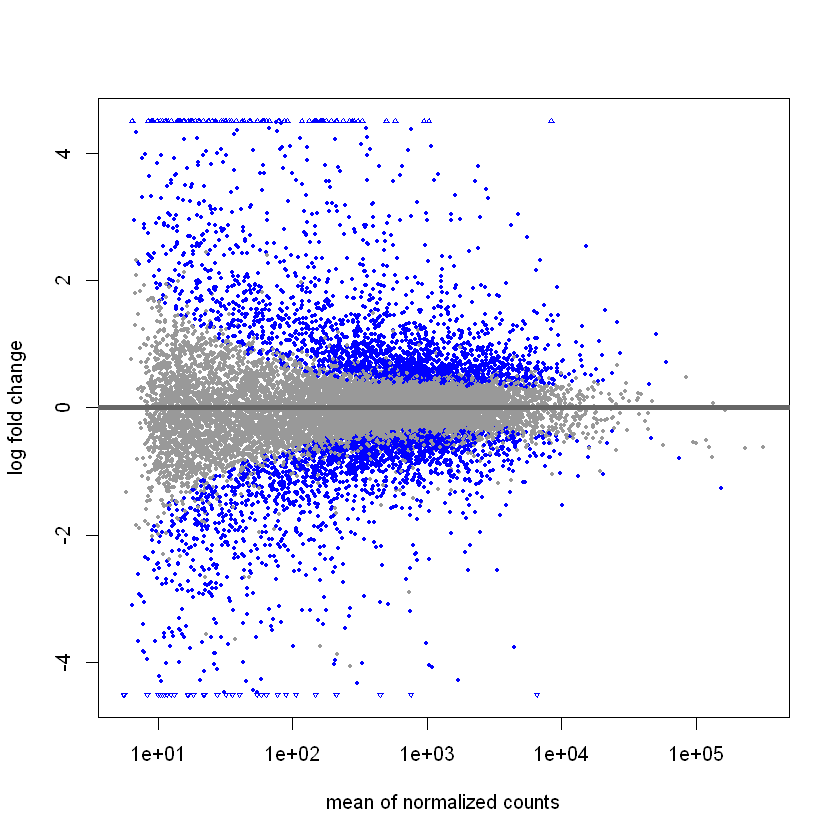

In [18]:
# Graphical Visualizations of the DE genes – MA plot (shows the log2 fold changes of the genes (each dot is a gene) 
# over the mean of normalized counts for all samples in my data)

plotMA(res)

Positive log2 fold changes values represent upregulated genes in sensitive compared to resistant group 
Negative log2 fold changes values represent dowregulated genes in sensitive compared to resistant group 

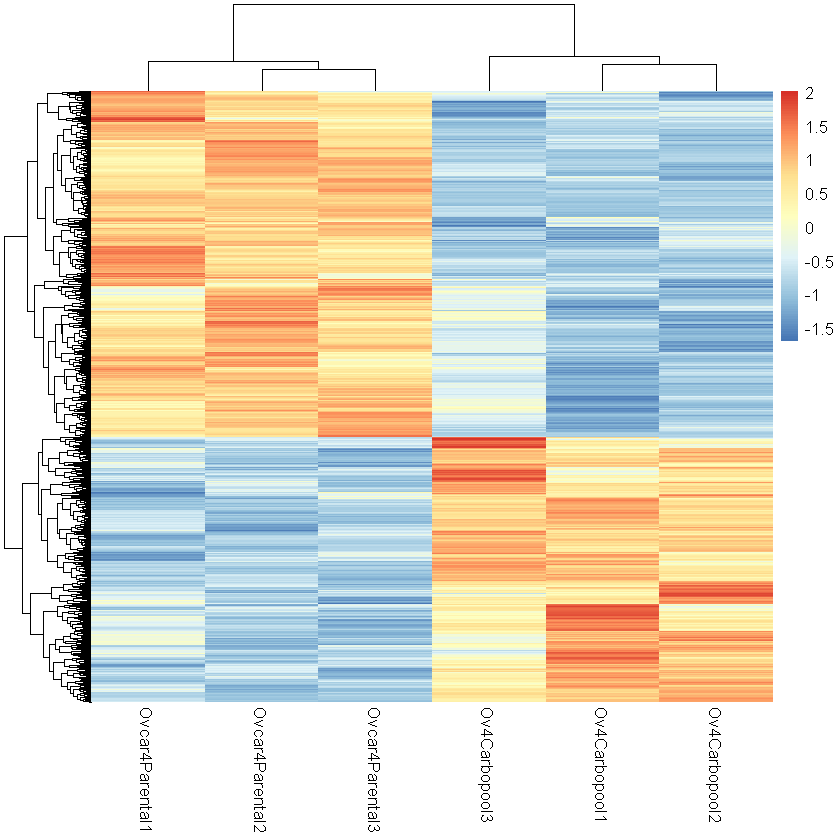

In [19]:
# Graphical Visualizations of the differentially expressed genes, subseting the DE genes with padj < 0.05 and log2FC > |1| i.e. 
# at least two-fold change in expression

library(pheatmap)

de.sign <- subset(res, padj < 0.05 & abs(log2FoldChange) >1 )

de.sign.genes <- rownames(de.sign)

scale.dat <- t(scale(t(assay(vsd)[de.sign.genes,])))

pheatmap(scale.dat[de.sign.genes,], cluster_rows=TRUE, show_rownames=FALSE, cluster_cols=TRUE)


In [30]:
# Annotation of output tables 

BiocManager::install('AnnotationDbi')
library(AnnotationDbi)
library(org.Hs.eg.db)


res.df <- as.data.frame(res)

res.annot <- mapIds(org.Hs.eg.db, keys = rownames(res.df), keytype = "ENSEMBL", column = "SYMBOL")

res.df.annot <- cbind(res.df,gene.symbol = res.annot) #binding the annotations to the sign.df

head(res.df.annot)

write.csv(res.df.annot, file = "DE_sensitiveVSresistant_results_wGeneSymbol.csv")


'getOption("repos")' replaces Bioconductor standard repositories, see
'?repositories' for details

replacement repositories:
    CRAN: https://cran.r-project.org


Bioconductor version 3.15 (BiocManager 1.30.19), R 4.2.1 (2022-06-23 ucrt)

Old packages: 'bookdown', 'broom', 'bslib', 'cli', 'digest', 'doRNG',
  'evaluate', 'formatR', 'highr', 'htmlwidgets', 'httpuv', 'isoband',
  'maptools', 'nlme', 'purrr', 'rmarkdown', 'RSQLite', 'shiny', 'tidytree',
  'tinytex', 'vctrs', 'xfun', 'yulab.utils'

'select()' returned 1:many mapping between keys and columns



,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,gene.symbol
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
ENSG00000000003,905.4021,0.1602191,0.1636002,0.9793336,0.32741517,0.5368985,TSPAN6
ENSG00000000419,1853.1710,-0.3647585,0.1704552,-2.1399081,0.03236219,0.1119807,DPM1
ENSG00000000457,179.9834,-0.4548143,0.2299656,-1.9777490,0.04795703,0.1488792,SCYL3
ENSG00000000460,540.8623,0.2763033,0.2061613,1.3402284,0.18017112,0.3695566,C1orf112
ENSG00000000971,619.9203,0.6099314,0.4227484,1.4427763,0.14908348,0.3263940,CFH
ENSG00000001036,1311.1453,0.1640071,0.1954976,0.8389214,0.40151344,0.6102762,FUCA2


function (expr) 
{
    enexpr(expr)
}
<bytecode: 0x000002324c344008>
<environment: namespace:rlang>

'getOption("repos")' replaces Bioconductor standard repositories, see
'?repositories' for details

replacement repositories:
    CRAN: https://cran.r-project.org


Bioconductor version 3.15 (BiocManager 1.30.19), R 4.2.1 (2022-06-23 ucrt)

Old packages: 'bookdown', 'broom', 'bslib', 'cli', 'digest', 'doRNG',
  'evaluate', 'formatR', 'highr', 'htmlwidgets', 'httpuv', 'isoband',
  'maptools', 'nlme', 'purrr', 'rmarkdown', 'RSQLite', 'shiny', 'tidytree',
  'tinytex', 'vctrs', 'xfun', 'yulab.utils'



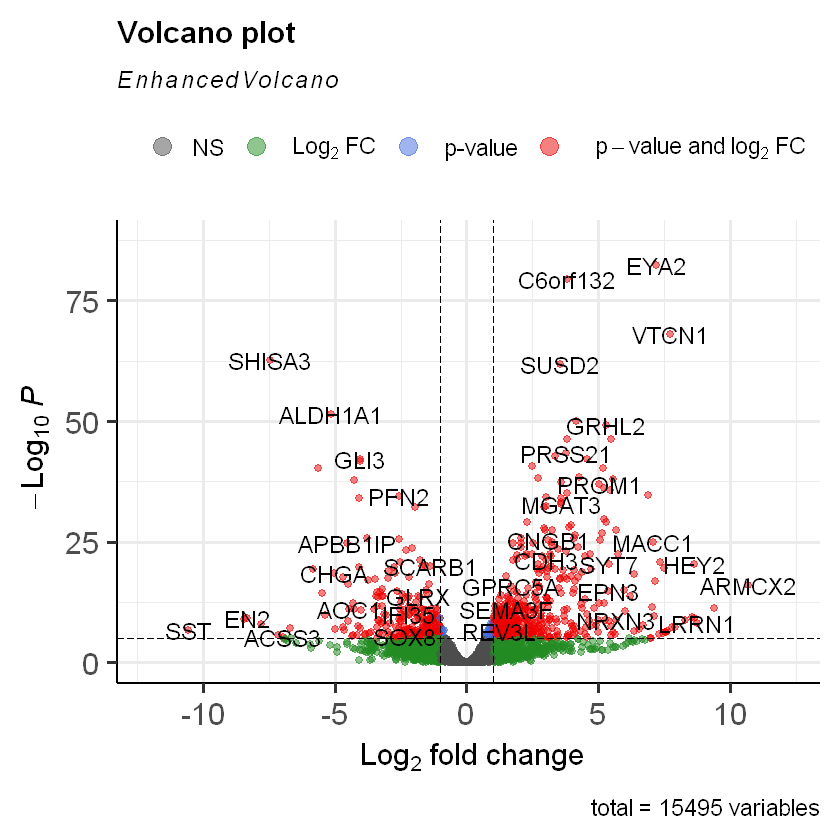

In [31]:
# Using volcano plot to visualize the Log2Fold changes of all genes (again each dot represents a gene) plotted against 
# the -Log10 Adjusted pvalue.

suppressPackageStartupMessages(expr)

BiocManager::install('EnhancedVolcano')
library(EnhancedVolcano)


EnhancedVolcano(res.df.annot,
    lab = res.df.annot$gene.symbol,
    x = 'log2FoldChange',
    y = 'padj')


In red are genes with padj < 0.05 and log2fold change more or less than 1. 
They are either differently upregulated (right) or downregulated (left) in sensitive samples compare to resistant.

# Gene set enrichment analysis

In [28]:
# Performing Pre-Ranked Gene Set Enrichment Analysis (GSEA Pre-Ranked) to understand better what biological processes 
# and pathways are affected 
suppressPackageStartupMessages(expr)

library(fgsea)

library(data.table)

library(ggplot2)

library(qusage)

function (expr) 
{
    enexpr(expr)
}
<bytecode: 0x000002324c344008>
<environment: namespace:rlang>

In [33]:
# Loading DE results

DE.res <- read.csv("DE_sensitiveVSresistant_results_wGeneSymbol.csv", header = TRUE, row.names = 1)
head(DE.res)

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,gene.symbol
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
ENSG00000000003,905.4021,0.1602191,0.1636002,0.9793336,0.32741517,0.5368985,TSPAN6
ENSG00000000419,1853.1710,-0.3647585,0.1704552,-2.1399081,0.03236219,0.1119807,DPM1
ENSG00000000457,179.9834,-0.4548143,0.2299656,-1.9777490,0.04795703,0.1488792,SCYL3
ENSG00000000460,540.8623,0.2763033,0.2061613,1.3402284,0.18017112,0.3695566,C1orf112
ENSG00000000971,619.9203,0.6099314,0.4227484,1.4427763,0.14908348,0.3263940,CFH
ENSG00000001036,1311.1453,0.1640071,0.1954976,0.8389214,0.40151344,0.6102762,FUCA2


In [34]:
# Loading the Gene Ontology Collection

gmt.file <- read.gmt("c5.go.bp.v7.4.symbols.gmt")

In [35]:
# Ranking DE results by decreasing Log2 Fold-change and then creating a named vector of the log2 fold changes 
# with the names being the gene symbols.

DE.res.ranked <- DE.res[order(DE.res$log2FoldChange, decreasing = T), ]

DE.ranks <- setNames(DE.res.ranked$log2FoldChange, DE.res.ranked$gene.symbol)

In [36]:
# Running the fgsea function

fgseaRes <- fgsea(gmt.file, DE.ranks, minSize=15, maxSize=500)

head(fgseaRes)

pathway,pval,padj,log2err,ES,NES,size,leadingEdge
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<list>
GOBP_2_OXOGLUTARATE_METABOLIC_PROCESS,0.9197761,1.0000000,0.04632278,0.2515517,0.6027168,15,"IDH2 , OGDH , ADHFE1, DLD , DLST , L2HGDH"
GOBP_3_PHOSPHOADENOSINE_5_PHOSPHOSULFATE_METABOLIC_PROCESS,0.1065217,0.3215889,0.20207171,-0.5132048,-1.3644322,18,"SULT1C2, SULT4A1, SLC26A1, SULT1A3, SULT1A1, SULT1A4, ENPP1"
GOBP_3_UTR_MEDIATED_MRNA_DESTABILIZATION,0.9347015,1.0000000,0.04558782,0.2414299,0.5784649,15,"UPF1 , ZFP36L1, ZFP36 , ZC3H12A, ZFP36L2, KHSRP , TARDBP"
GOBP_3_UTR_MEDIATED_MRNA_STABILIZATION,0.7495362,0.9364455,0.05547933,0.3181787,0.7697295,17,"MYD88 , MAPKAPK2, ZFP36 , TENT4B , ELAVL1 , HNRNPA0 , TARDBP , MAPK14"
GOBP_ACETYL_COA_BIOSYNTHETIC_PROCESS,0.9317774,1.0000000,0.04397593,0.2322499,0.5972675,21,"PDP1 , ACSS1, PDK3 , DIP2A, DLD , PDPR"
GOBP_ACETYL_COA_METABOLIC_PROCESS,0.9002320,1.0000000,0.05736674,-0.2322340,-0.7003968,31,"NUDT7, PDK4"


In [45]:
# ordered from most sign. to least 

topPathways <- fgseaRes[order(padj)]

topPathways$leadingEdge <- NULL

head(topPathways)

pathway,pval,padj,log2err,ES,NES,size
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
GOBP_SKIN_DEVELOPMENT,4.680365e-16,1.615662e-12,1.0276699,0.6608134,2.406081,197
GOBP_EPIDERMIS_DEVELOPMENT,2.583387e-14,4.458926e-11,0.9759947,0.6216581,2.290990,224
GOBP_EPITHELIAL_CELL_DIFFERENTIATION,4.401784e-12,3.798740e-09,0.8870750,0.5019336,1.973844,449
GOBP_TISSUE_MORPHOGENESIS,3.807005e-12,3.798740e-09,0.8870750,0.4987493,1.968925,478
GOBP_MORPHOGENESIS_OF_AN_EPITHELIUM,1.834514e-11,1.266549e-08,0.8634154,0.5088502,1.988096,410
GOBP_EXTERNAL_ENCAPSULATING_STRUCTURE_ORGANIZATION,2.397942e-11,1.379616e-08,0.8634154,0.5602733,2.095861,265


# Pathway Enrichment Analysis

In [46]:
# selecting sign. DE genes

library("AnnotationDbi")
library("org.Hs.eg.db")


# adding symbol column for further pathway analysis

res$symbol = mapIds(org.Hs.eg.db,
                    keys=row.names(res), 
                    column="SYMBOL",
                    keytype="ENSEMBL",
                    multiVals="first")

sig_genes <- res[res$padj <= 0.05 & !is.na(res$padj), "symbol"]

print(paste("Total number of significant genes:", length(sig_genes)))


'select()' returned 1:many mapping between keys and columns



[1] "Total number of significant genes: 3442"


In [47]:
write.table(sig_genes, file="significant_genes.txt", row.names=FALSE, col.names=FALSE, quote=FALSE)

Performing pathway analysis online where I uploaded "significant_genes.txt" to Reactome website (https://reactome.org/PathwayBrowser/#TOOL=AT). Selectied parameters:“Project to Humans”

In [49]:
reactome_res <- read.csv("reactome_result.csv")

In [52]:
# top dysregulated pathways

reactome_res %>% dplyr::select(2, 6) %>% head(10)

,Pathway.name,Entities.pValue
,<chr>,<dbl>
1,Non-integrin membrane-ECM interactions,0.000027673
2,Integrin cell surface interactions,0.000111321
3,Elastic fibre formation,0.000163532
4,Extracellular matrix organization,0.000178736
5,Cell junction organization,0.000218753
6,Anchoring fibril formation,0.000390001
7,Molecules associated with elastic fibres,0.000396877
8,Laminin interactions,0.000769198
9,Cell-Cell communication,0.000863727


Gene Ontology Biological Pathways (GOBP) related to the tumor micro-environment, particularly the extracellular matrix, were enriched in carboplatin-resistant cells